In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import yfinance as yf
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

In [2]:
thyao = yf.download("THYAO.IS", period="max", start="2020-01-02")
thyao.drop(["Close"], axis=1, inplace=True)
thyao.rename(columns={"Adj Close": "Close"}, inplace=True)
thyao

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,14.50,14.84,14.48,14.83,109370878
2020-01-03,14.67,14.73,14.09,14.27,153873531
2020-01-06,14.03,14.08,13.50,13.57,136423179
2020-01-07,13.79,13.86,13.52,13.54,154729229
2020-01-08,13.05,13.62,13.03,13.50,197012716
...,...,...,...,...,...
2021-08-27,12.75,12.75,12.53,12.68,64421920
2021-08-31,12.72,12.78,12.64,12.68,53636208
2021-09-01,12.73,12.98,12.73,12.90,89007860


In [3]:
# True Range as Volatility proxy
thyao["TR"] = thyao.Close - thyao.Open

In [4]:
# Normalize volume and tr for each day by
# subtracting the mean of the last 20 days
# and dividing by the last 20 days’ standard
# deviation for each
thyao["TR_norm"] = np.nan
thyao["Vol_norm"] = np.nan

In [5]:
for i in range(22, len(thyao)):
    data = thyao.iloc[i - 22 : i, [4, 5]]

    Vol_mean = np.mean(data.Volume)
    Vol_stdd = np.std(data.Volume)
    TR_mean = np.mean(data.TR)
    TR_stdd = np.std(data.TR)

    thyao.loc[thyao.index[i], "Vol_norm"] = (
        thyao.loc[thyao.index[i], "Volume"] - Vol_mean
    ) / Vol_stdd
    thyao.loc[thyao.index[i], "TR_norm"] = (
        thyao.loc[thyao.index[i], "TR"] - TR_mean
    ) / TR_stdd

thyao.dropna(inplace=True)

<AxesSubplot:xlabel='Vol_norm', ylabel='TR_norm'>

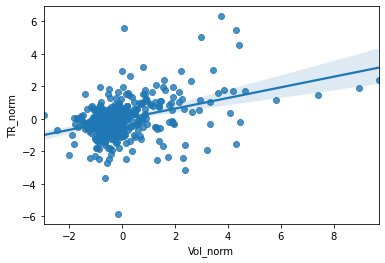

In [6]:
# Scatter plot with regression line
sns.regplot(
    data=thyao,
    x="Vol_norm",
    y="TR_norm",
)

In [7]:
# OLS
lm = OLS(thyao.TR_norm, add_constant(thyao.Vol_norm))
res = lm.fit()
res.summary()

C:\Users\murat\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                TR_norm   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     69.30
Date:                Sat, 04 Sep 2021   Prob (F-statistic):           1.41e-15
Time:                        09:33:22   Log-Likelihood:                -607.84
No. Observations:                 395   AIC:                             1220.
Df Residuals:                     393   BIC:                             1228.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0211      0.057     -0.371      0.711      -0.133       0.091
Vol_norm       0.3271      0.039      8.325      0.000       0.250       0.404
==============================================================================
Omnibus:                       50.548   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              385.946
Skew:                           0.097   Prob(JB):                     1.56e-84
Kurtosis:                       7.839   Cond. No.                         1.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""